<a href="https://colab.research.google.com/github/sylee20/kaggle_competition/blob/main/nb_amex_eda_which_makes_sense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os, gc

# Predefine functions

In [ ]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
      col_type = df[col].dtype

      if col_type != object:
        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
          if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
            df[col] = df[col].astype(np.int8)
          elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
            df[col] = df[col].astype(np.int16)
          elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)
          elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
            df[col] = df[col].astype(np.int64)
        else:
          if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
          else: 
            df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100*(start_mem - end_mem) / start_mem))
    return df

#Load data

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files
my_upload = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          10271        312  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           5701        177  0.9705882        
mohamedharris/supermart-grocery-sales-retail-analytics-dataset  Supermart Grocery Sales - Retail Analytics Dataset  191KB  2022-06-12 16:14:44            840         44  0.88235295       
sameepvani/nasa-nearest-earth-objects                       

In [ ]:
! kaggle datasets download -d raddar/amex-data-integer-dtypes-parquet-format

100% 4.06G/4.07G [00:59<00:00, 74.1MB/s]
100% 4.07G/4.07G [01:00<00:00, 72.8MB/s]


In [ ]:
! mkdir input

In [ ]:
! unzip amex-data-integer-dtypes-parquet-format.zip -d input

Archive:  amex-data-integer-dtypes-parquet-format.zip
  inflating: input/test.parquet      
  inflating: input/train.parquet     


In [ ]:
print(os.listdir('./input'))

['test.parquet', 'train.parquet']


In [ ]:
my_upload = files.upload()

Saving train_labels.csv to train_labels.csv


In [ ]:
! mv train_labels.csv input

In [ ]:
train_df = pd.read_parquet('./input/train.parquet')
test_df = pd.read_parquet('./input/test.parquet')
train_labels_df = pd.read_csv('./input/train_labels.csv')
print('train_df shape: ', train_df.shape)
print('train_labels_df shape: ', train_labels_df.shape)
print('test_df shape: ', test_df.shape)

train_df shape:  (5531451, 190)
train_labels_df shape:  (458913, 2)
test_df shape:  (11363762, 190)


In [ ]:
train_df = pd.merge(train_df, train_labels_df)

#Label


## 배운 것:  
customer_ID에 dupicate 값이 있는지 확인할 생각을 못했다. duplicated()라는 함수를 알아둘 것.   
Target이 imbalanced. stratifiedKFold를 사용하는 것이 좋으며, eval metrics도 이것을 고려해 선택해야(competition metric이 이미 이것을 고려한 metric임)

In [ ]:
train_labels_df.isna().sum()

customer_ID    0
target         0
dtype: int64

In [ ]:
train_labels_df['customer_ID'].duplicated().sum()

0

In [ ]:
label_stats = pd.DataFrame({'absolute':train_labels_df['target'].value_counts(),
                            'relative':train_labels_df['target'].value_counts() / len(train_labels_df)})
label_stats['absolute upsampled'] = label_stats['absolute']*np.array([20,1])
label_stats['relative upsampled'] = label_stats['absolute upsampled'] / label_stats['absolute upsampled'].sum()
label_stats

,absolute,relative,absolute upsampled,relative upsampled
0,340085,0.741066,6801700,0.98283
1,118828,0.258934,118828,0.01717


# Data

## Data 전체 파악

In [ ]:
#customer_ID의 데이터 타입 변환 (str > int64)
print('train_df 변환 전 customer_ID 종류 수: ', train_df['customer_ID'].nunique())
train_df['customer_ID'] = train_df['customer_ID'].str[-16:].apply(int, base=16).astype(np.int64)
print('train_df 변환 후 customer_ID 종류 수: ', train_df['customer_ID'].nunique())

print('test_df 변환 전 customer_ID 종류 수: ', test_df['customer_ID'].nunique())
test_df['customer_ID'] = test_df['customer_ID'].str[-16:].apply(int, base=16).astype(np.int64)
print('test_df 변환 후 customer_ID 종류 수: ', test_df['customer_ID'].nunique())

train_df 변환 전 customer_ID 종류 수:  458913
train_df 변환 후 customer_ID 종류 수:  458913
test_df 변환 전 customer_ID 종류 수:  924621
test_df 변환 후 customer_ID 종류 수:  924621


In [ ]:
# S_2의 데이터 타입 변환 (str > datetime)
train_df['S_2'] = pd.to_datetime(train_df['S_2'] )
print(train_df['S_2'].dtype)

test_df['S_2'] = pd.to_datetime(test_df['S_2'] )
print(test_df['S_2'].dtype)

datetime64[ns]
datetime64[ns]


##배운 것:
The test data come from a different phase in the economic cycle than the training data. Our models have no way of learning the effect of the economic cycle.



In [ ]:
print('Train statement dates: ', train_df['S_2'].min(), train_df['S_2'].max(), train_df['S_2'].isna().sum())
print('Test statement dates: ', test_df['S_2'].min(), test_df['S_2'].max(), test_df['S_2'].isna().sum())

Train statement dates:  2017-03-01 00:00:00 2018-03-31 00:00:00 0
Test statement dates:  2018-04-01 2019-10-31 0


##배운 것:
* memory_usage() 함수의 사용  

* 데이터 메모리 사이즈가 크다.  
데이터나 모델의 필요 없는 카피를 가지고 잊지 말것.  
train 데이터는 전부 가지고 있어야 하지만
test 데이터는 한번에 load하지 않고 batch 단위로 process해도 된다.   
You may want to separate training and inference code into two notebooks so that you never have training and test data in memory at the same time. < 이건 무슨말인지 모르겠음


In [ ]:
print(f'Train data memory usage: {train_df.memory_usage().sum() / 1e9} GBytes')
print(f'Test data memory usage: {test_df.memory_usage().sum() / 1e9} GBytes')

NameError: ignored

## 배운 것:
info() 에 파라미터 설정하기  
There are many columns with missing values: Dropping all columns which have missing values is not a sensible strategy.  
There are many rows with missing values: Dropping all rows which have missing values is not a sensible strategy.  
Many decision-tree based algorithms can deal with missing values. If we choose such a model, we don't need to change the missing values.  
Neural networks and other estimators cannot deal with missing values. If we choose such a model, we need to impute values.

In [ ]:
train_df.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 190 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  int64         
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float32       
 3    D_39         5531451 non-null  int16         
 4    B_1          5531451 non-null  float32       
 5    B_2          5529435 non-null  float32       
 6    R_1          5531451 non-null  float32       
 7    S_3          4510907 non-null  float32       
 8    D_41         5529435 non-null  float32       
 9    B_3          5529435 non-null  float32       
 10   D_42         791314 non-null   float32       
 11   D_43         3873055 non-null  float32       
 12   D_44         5531451 non-null  int8          
 13   B_4          5531451 non-null  int16         
 14   D_45         5529434 non-null  float32       
 1

## Statements per customer

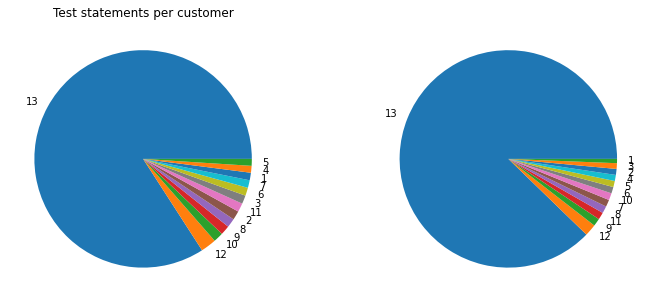

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_statements_count = train_df.groupby('customer_ID')['S_2'].count().value_counts().rename('Train statements per customer')
ax1.pie(train_statements_count, labels=train_statements_count.index)
ax1.set_title(train_statements_count.name)
test_statements_count = test_df.groupby('customer_ID')['S_2'].count().value_counts().rename('Test statements per customer')
ax2.pie(test_statements_count, labels=test_statements_count.index)
ax1.set_title(test_statements_count.name)
plt.show()

Let's find out when these customers got their last statement. The histogram of the last statement dates shows that every train customer got his last statement in March of 2018. The first four Saturdays (March 3, 10, 17, 24) have more statements than an average day.

The test customers are split in two: half of them got their last statement in April of 2019 and half in October of 2019. As was discussed here, the April 2019 data is used for the public leaderboard and the October 2019 data is used for the private leaderboard. << 학습 예측에 이를 어떻게 적용해야할지....

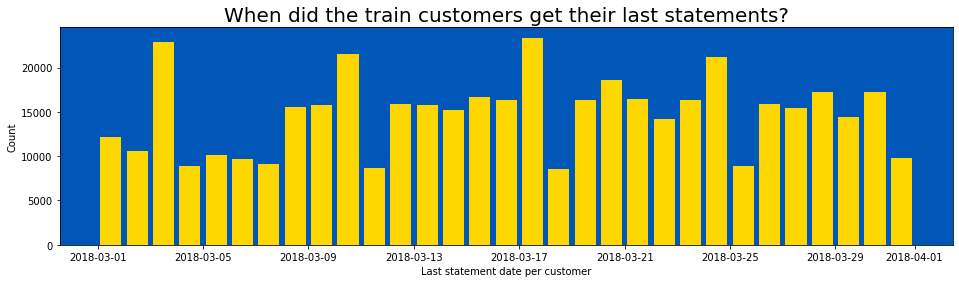

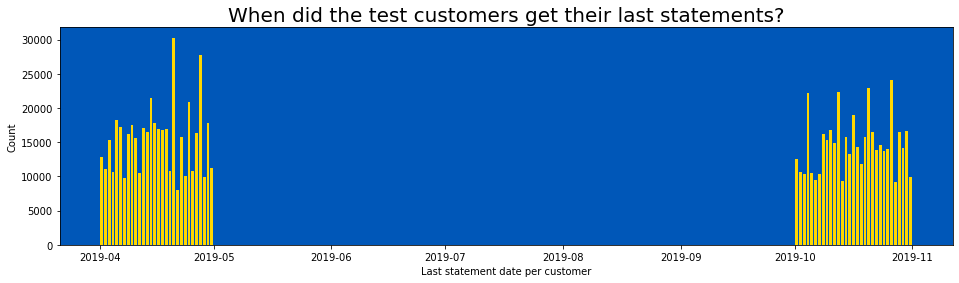

In [ ]:
temp = train_df.groupby('customer_ID')['S_2'].max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"),
         rwidth=0.8, color='#ffd700')
plt.title('When did the train customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

temp = test_df.groupby('customer_ID')['S_2'].max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"),
         rwidth=0.74, color='#ffd700')
plt.title('When did the test customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

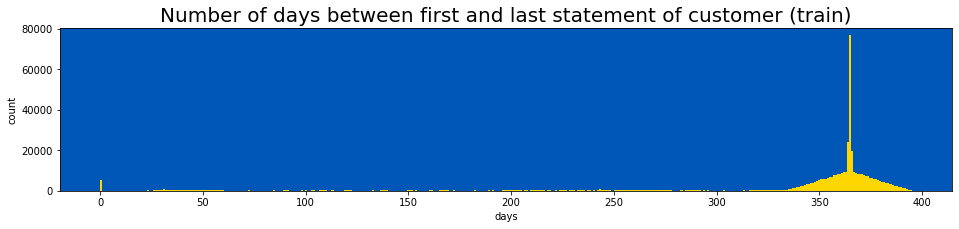

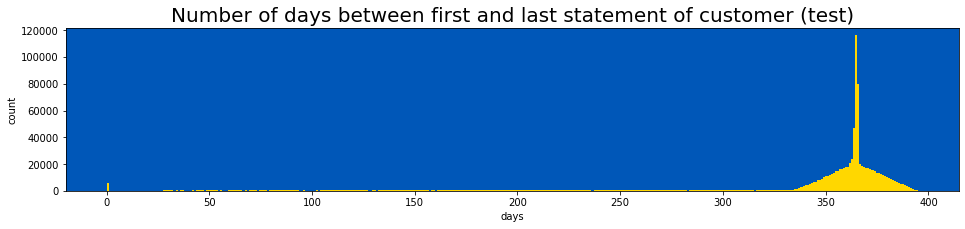

In [ ]:
temp = train_df.groupby('customer_ID')['S_2'].agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max']-temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (train)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()

temp = test_df.groupby('customer_ID')['S_2'].agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max']-temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (test)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


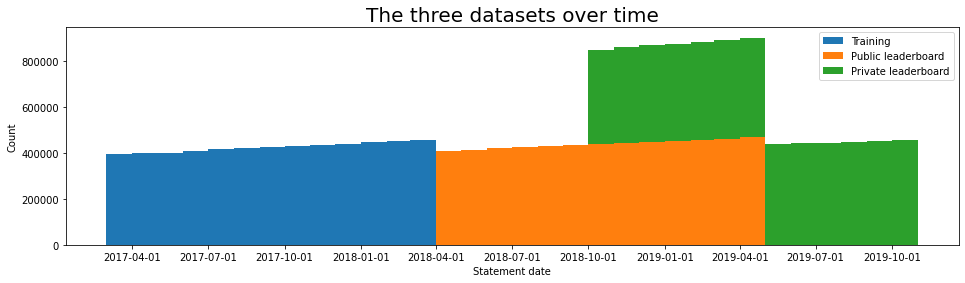

In [ ]:
temp = pd. concat([train_df[['customer_ID', 'S_2']], test_df[['customer_ID', 'S_2']]], axis=0)
temp.set_index('customer_ID', inplace=True)
temp['last_month'] = temp.groupby('customer_ID')['S_2'].max().dt.month
last_month = temp['last_month'].values

plt.figure(figsize=(16, 4))
plt.hist([temp['S_2'][temp['last_month']==3],
          temp['S_2'][temp['last_month']==4],
          temp['S_2'][temp['last_month']==10]],
         bins=pd.date_range('2017-03-01', '2019-11-01', freq='MS'),
         label = ['Training', 'Public leaderboard', 'Private leaderboard'],
         stacked=True)
plt.xticks(pd.date_range('2017-03-01', '2019-11-01', freq='QS'))
plt.xlabel('Statement date')
plt.ylabel('Count')
plt.title('The three datasets over time', fontsize=20)
plt.legend()
plt.show()


##Distribution of missing values over time
missing value가 있는 칼럼이 너무 많아서 아예 distribution을 볼 생각을 못했는데 보는게 맞는지도....

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


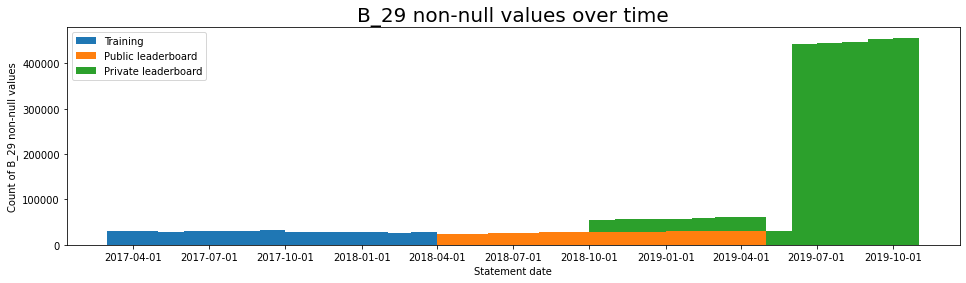

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


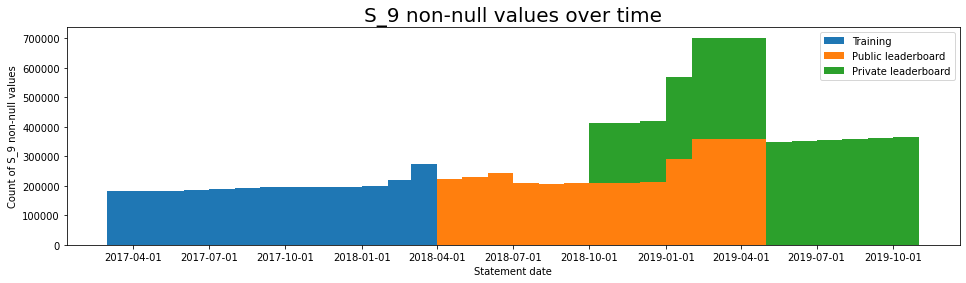

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


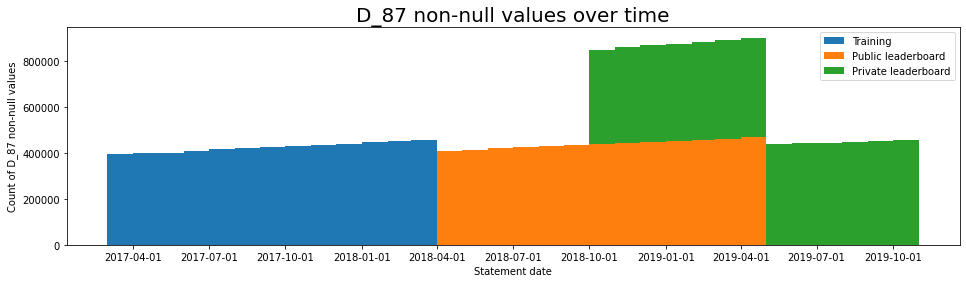

In [ ]:
for f in ['B_29', 'S_9', 'D_87']:
  temp = pd.concat([train_df[[f, 'S_2']], test_df[[f, 'S_2']]], axis=0)
  temp['last_month'] = last_month
  temp['has_f'] = ~temp[f].isna()

  plt.figure(figsize=(16, 4))
  plt.hist([temp['S_2'][temp['has_f'] & (temp['last_month']==3)],
            temp['S_2'][temp['has_f'] & (temp['last_month']==4)],
            temp['S_2'][temp['has_f'] & (temp['last_month']==10)]],
           bins=pd.date_range('2017-03-01', '2019-11-01', freq='MS'),
           label=['Training', 'Public leaderboard', 'Private leaderboard'],
           stacked=True)
  
  plt.xticks(pd.date_range('2017-03-01', '2019-11-01', freq='QS'))
  plt.xlabel('Statement date')
  plt.ylabel(f'Count of {f} non-null values')
  plt.title(f'{f} non-null values over time', fontsize=20)
  plt.legend()
  plt.show()

## Categorical features

##배운 것
Every feature has at most eight categories (including a nan category). One-hot encodings are feasible.
The distributions for target=0 and target=1 differ. This means that every feature gives some information about the target.

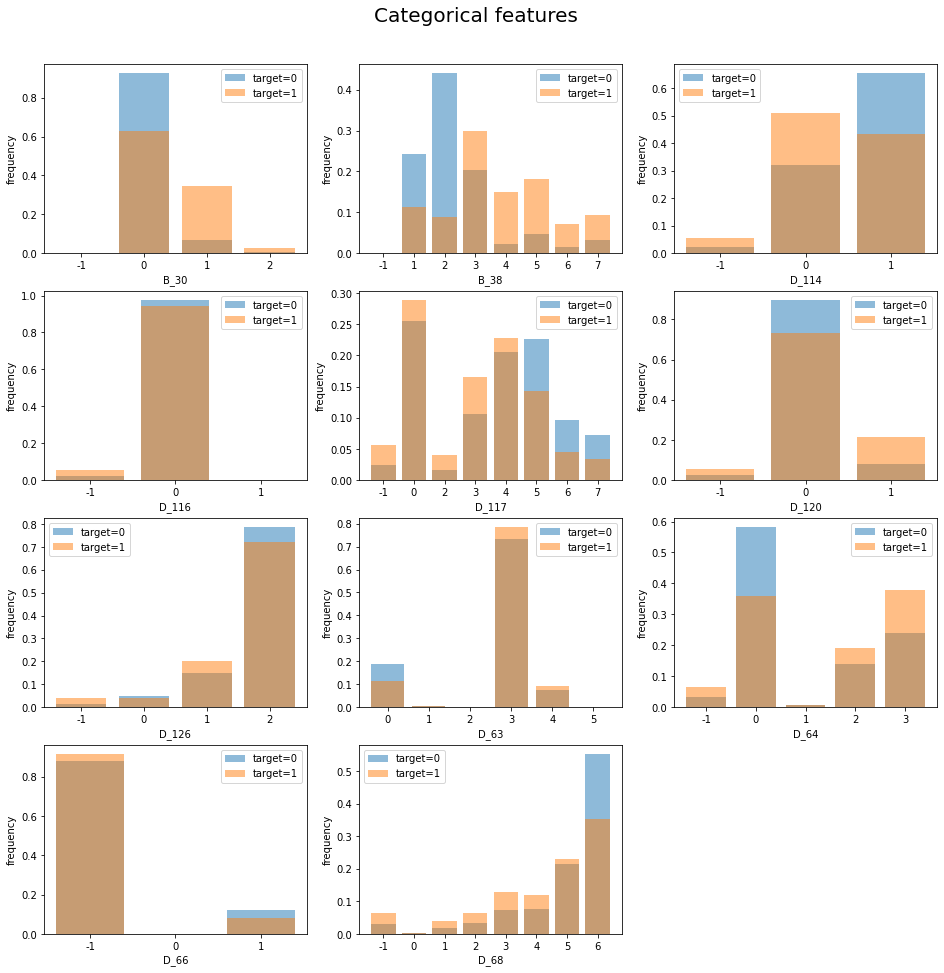

In [ ]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
  plt.subplot(4, 3, i+1)
  
  temp = pd.DataFrame(train_df[f][train_df['target']==0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
  temp.index.name = 'value'
  temp.reset_index(inplace=True)
  plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')

  temp = pd.DataFrame(train_df[f][train_df['target']==1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
  temp.index.name = 'value'
  temp.reset_index(inplace=True)
  plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')

  plt.xlabel(f)
  plt.ylabel('frequency')
  plt.legend()
  plt.xticks(temp.index, temp.value)

plt.suptitle('Categorical features', fontsize=20, y=0.93)
plt.show()
del temp




## The binary features
Two features are binary:

B_31 is always 0 or 1.
D_87 is always 1 or missing.

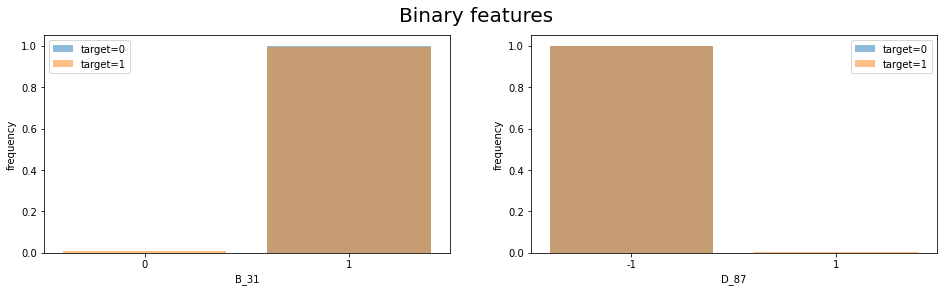

In [ ]:
bin_features = ['B_31', 'D_87']
plt.figure(figsize=(16, 4))
for i, f in enumerate(bin_features):
  plt.subplot(1, 2, i+1)
  temp = pd.DataFrame(train_df[f][train_df['target']==0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
  temp.index.name = 'value'
  temp.reset_index(inplace=True)
  plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')

  temp = pd.DataFrame(train_df[f][train_df['target']==1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
  temp.index.name = 'value'
  temp.reset_index(inplace=True)
  plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')

  plt.xlabel(f)
  plt.ylabel('frequency')
  plt.legend()
  plt.xticks(temp.index, temp.value)
plt.suptitle('Binary features', fontsize=20)
plt.show()
del temp

## Continuous features

191


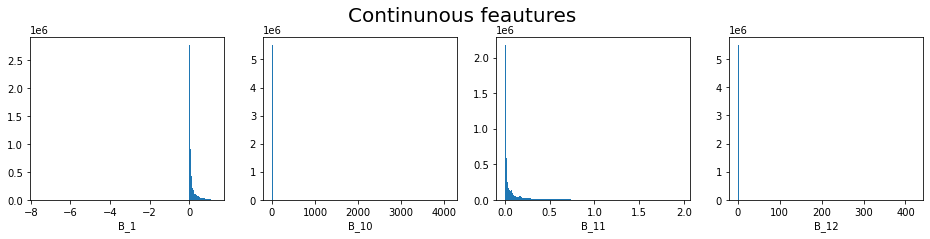

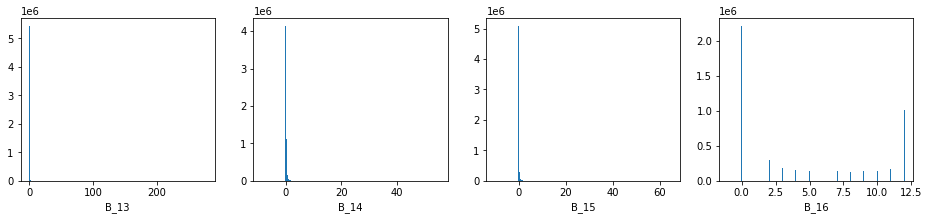

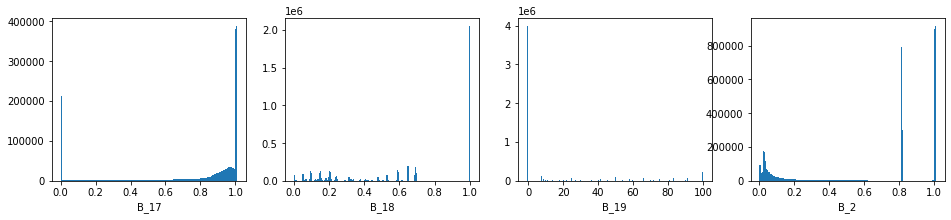

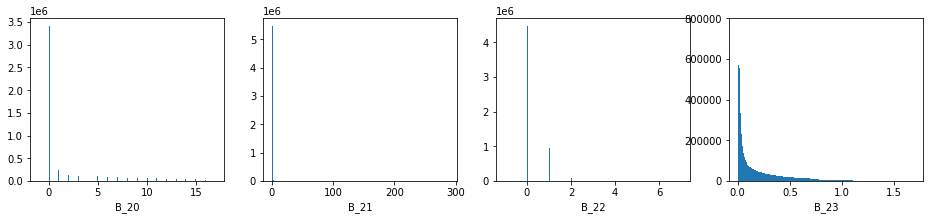

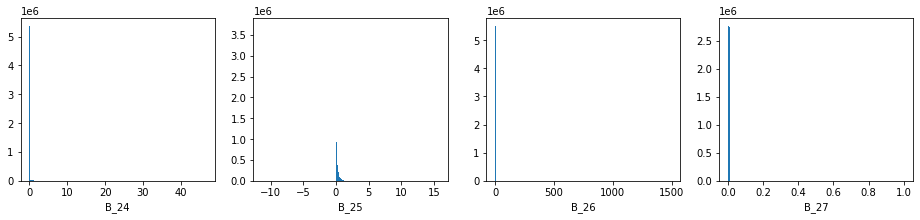

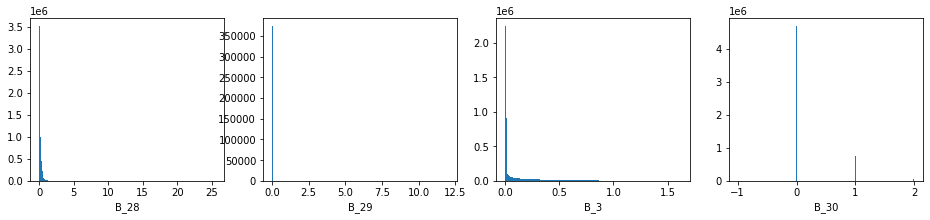

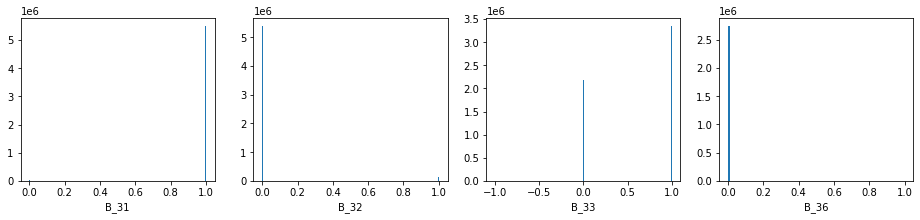

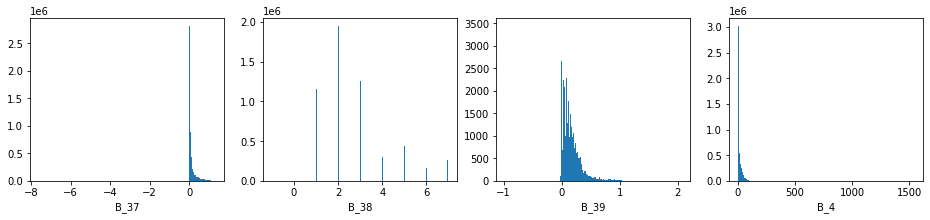

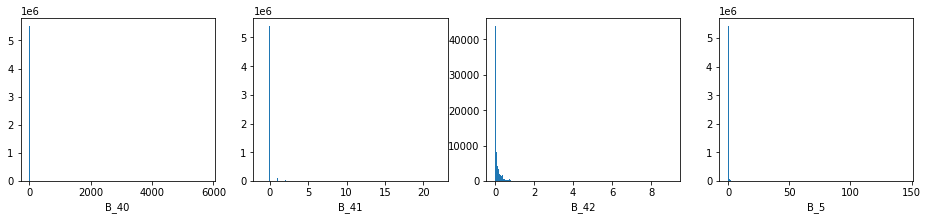

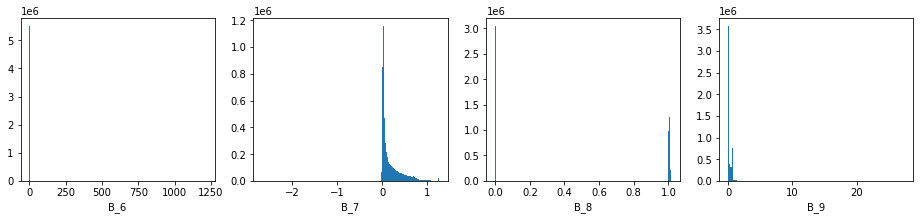

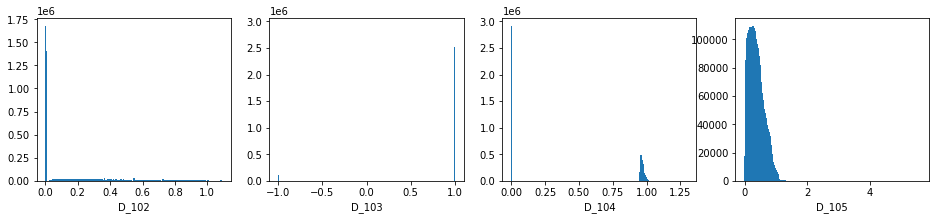

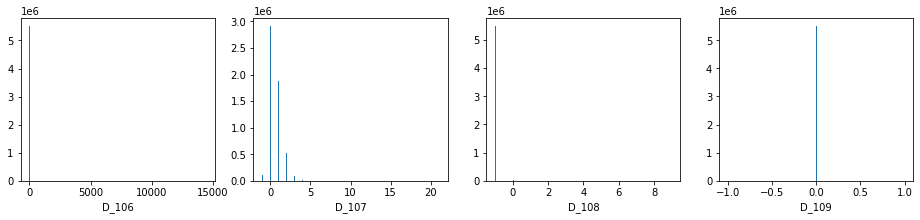

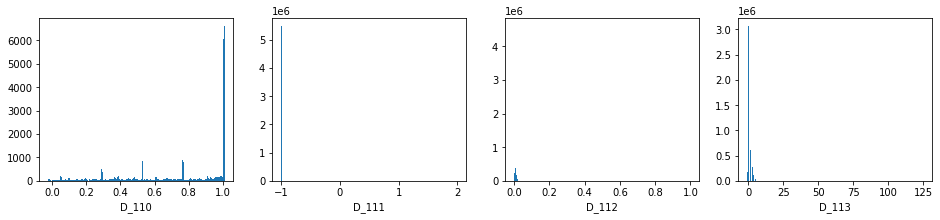

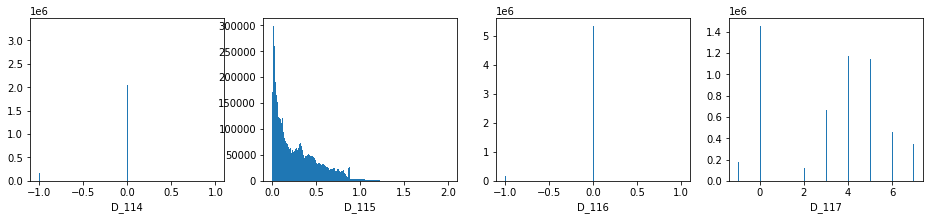

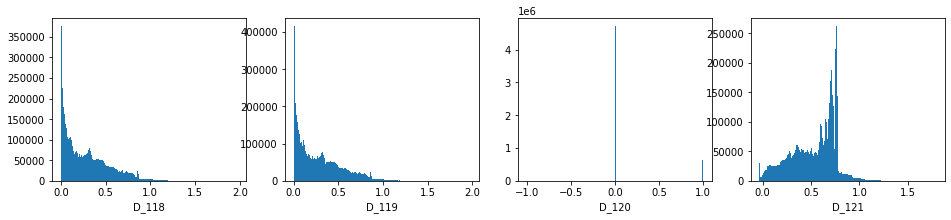

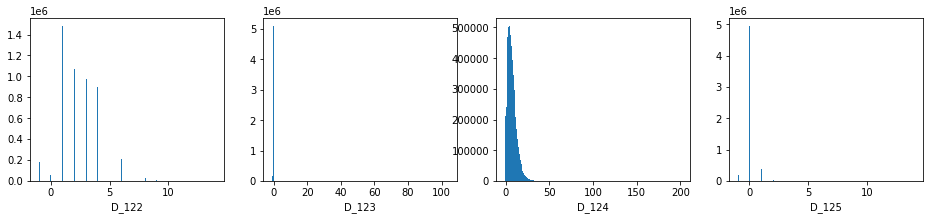

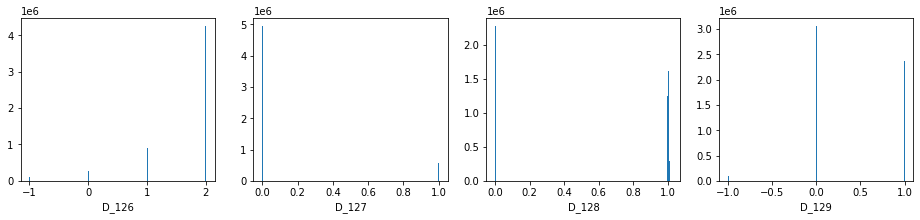

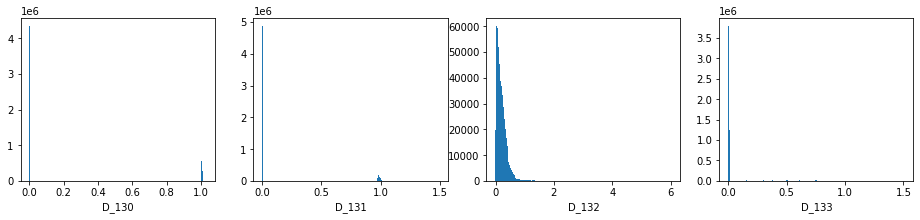

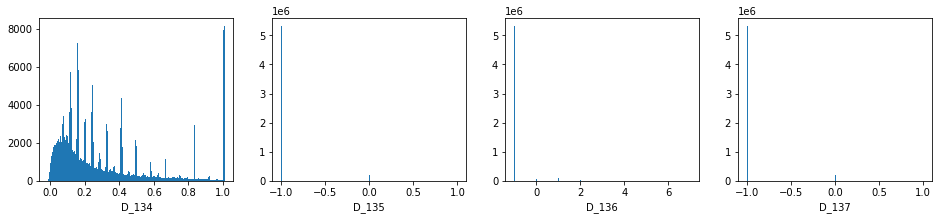

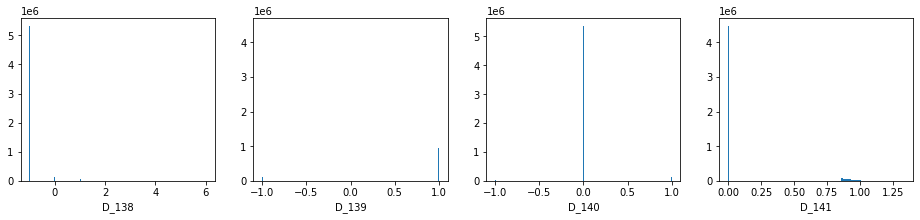

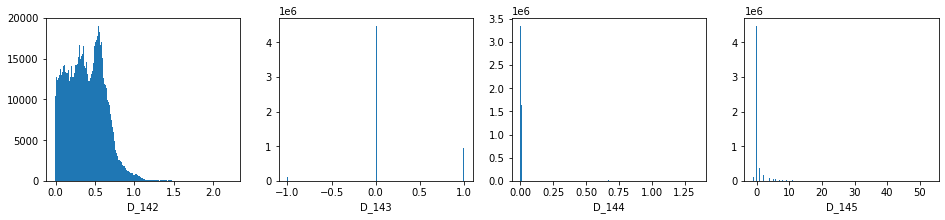

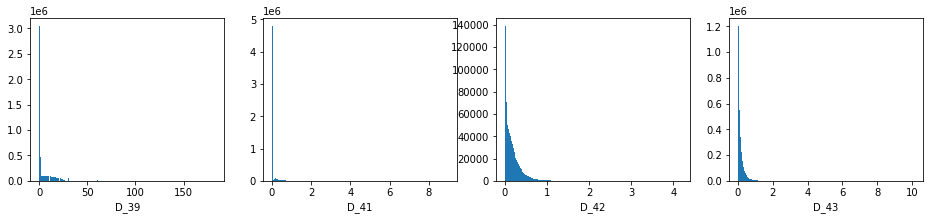

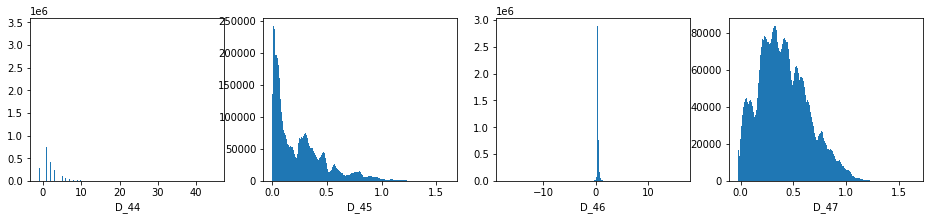

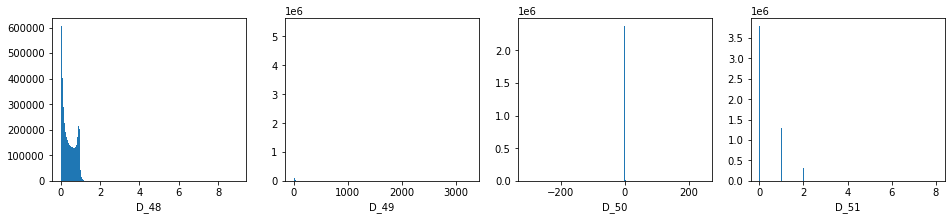

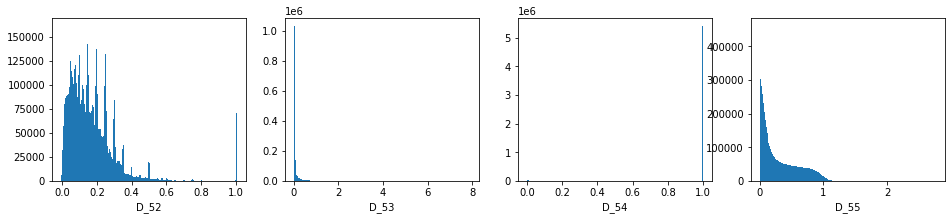

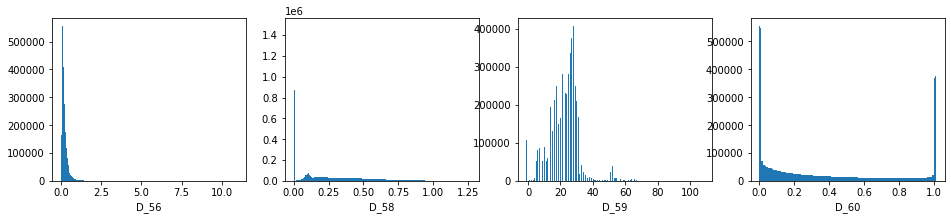

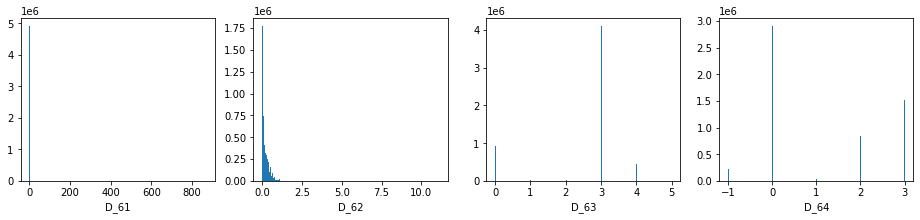

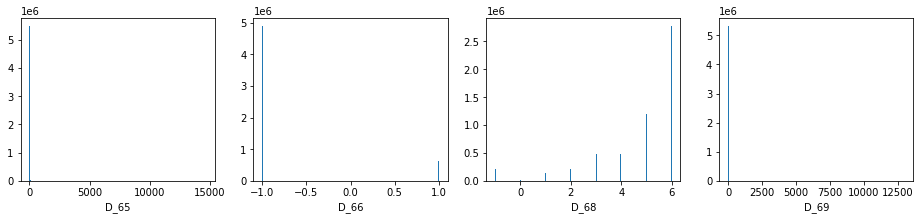

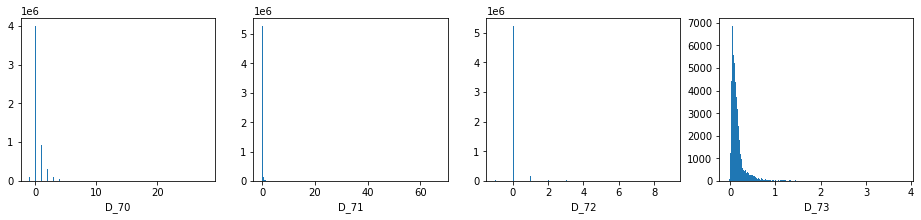

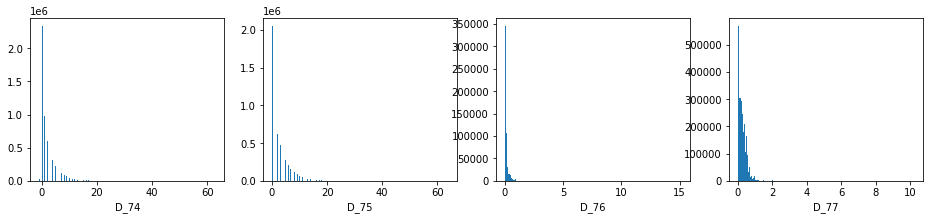

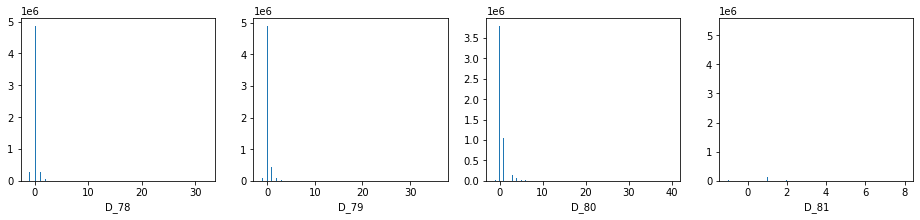

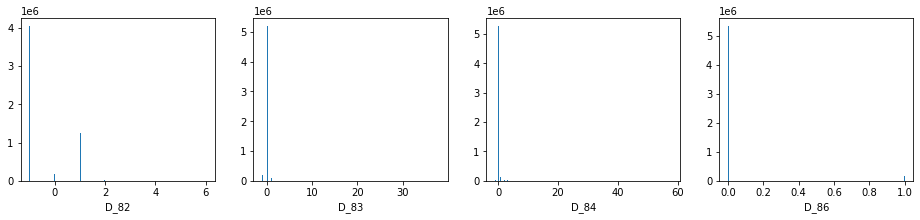

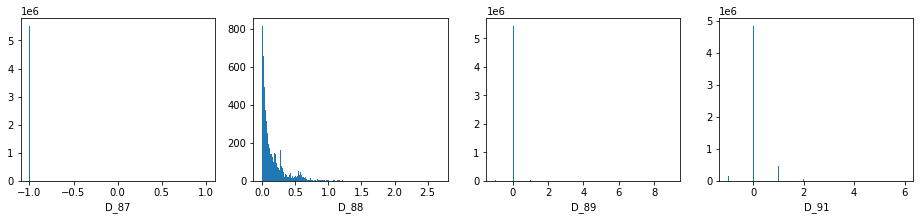

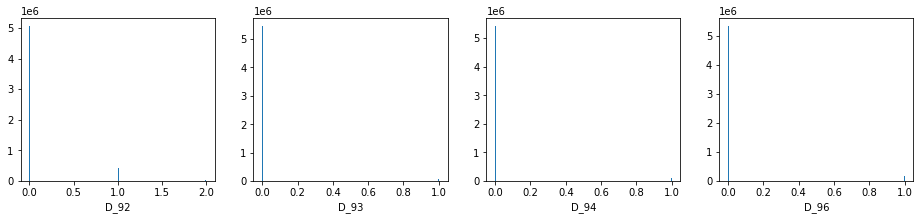

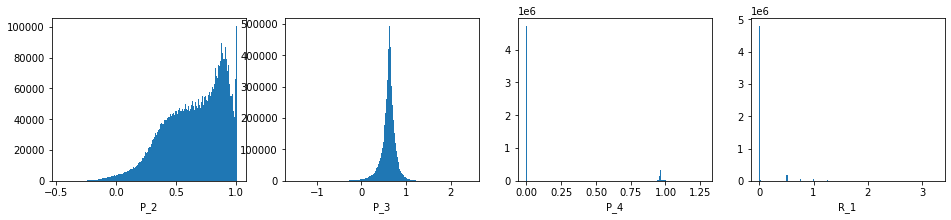

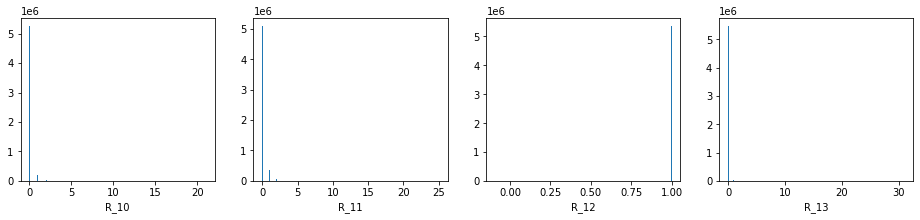

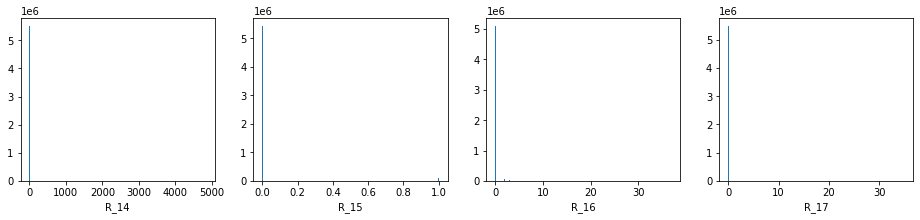

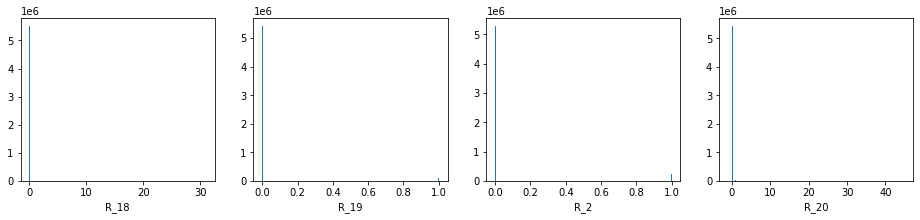

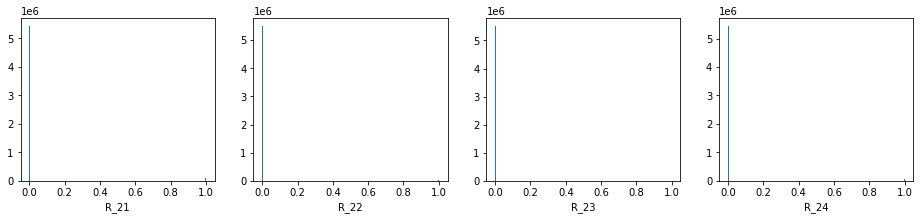

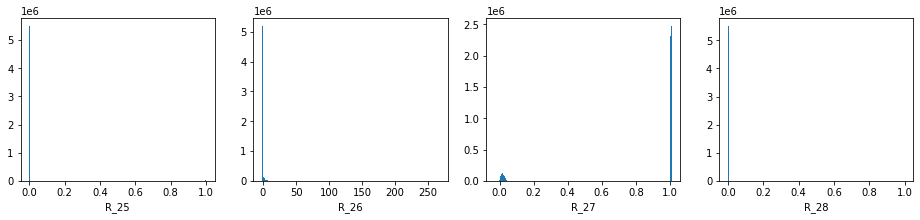

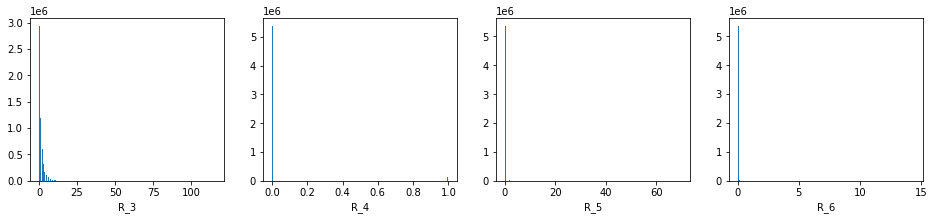

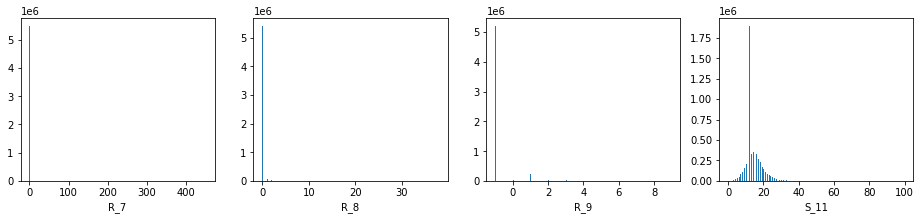

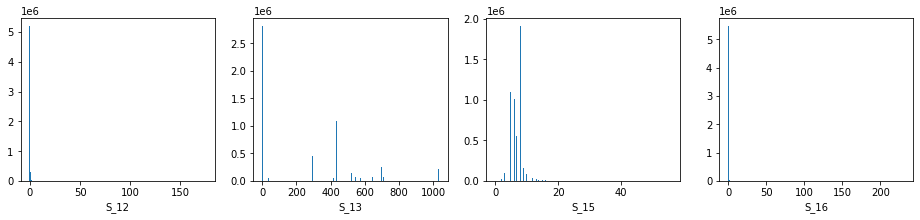

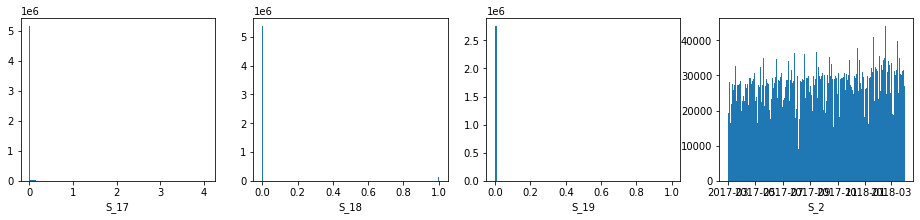

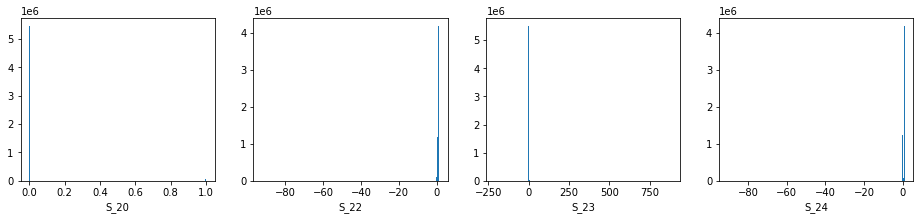

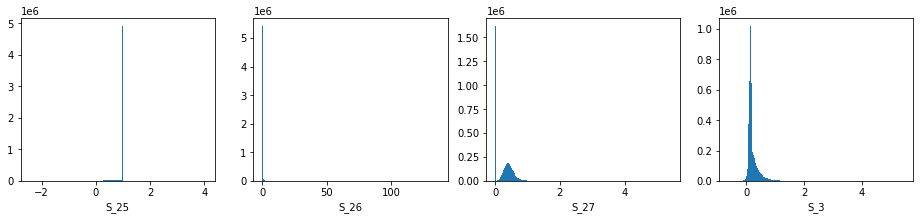

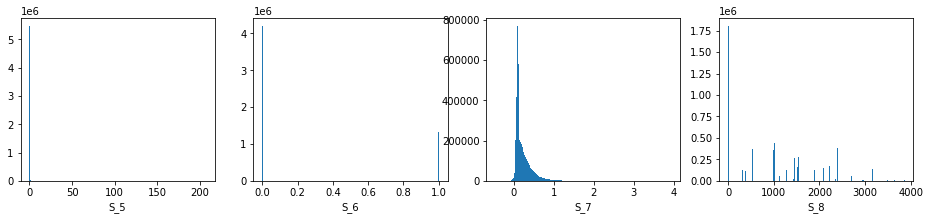

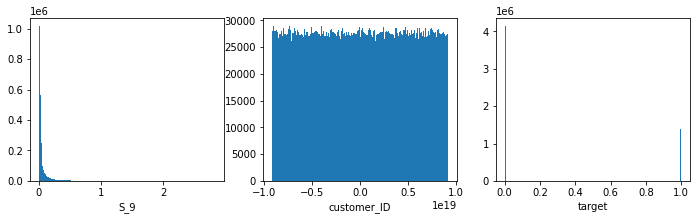

In [ ]:
cont_features = sorted([f for f in train_df.columns if i not in cat_features + bin_features + ['customer_ID', 'target', 'S_2']])
print(len(cont_features))
ncols = 4
for i, f in enumerate(cont_features):
  if i % ncols==0:
    if i > 0: plt.show()
    plt.figure(figsize=(16,3))
    if i == 0: plt.suptitle('Continunous feautures', fontsize=20, y=1.02)
  plt.subplot(1, ncols, i % ncols +1)
  plt.hist(train_df[f], bins=200)
  plt.xlabel(f)
plt.show()